## Init

In [1]:
!module load pytorch-gpu/py3/1.10.0
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-28d18bde-4df4-0105-0649-cfb6be8107a3)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import modellib
import datalib
import training
import conf
from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## Loading data 

In [3]:
dataset = datalib.SimulationBatch.load()

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


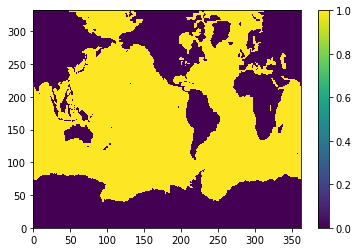

In [4]:
dataset.load_mask_bathy()
plt.pcolor(dataset.mask) ; plt.colorbar() ; plt.show()

## Data conversion

Remove annual cycles, average annually, infer mask, etc.

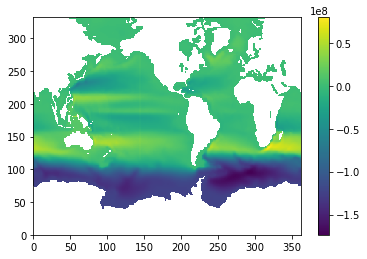

In [5]:
#dataset.convert2ssca()
dataset.convert2annual()
plt.pcolor(dataset[0][120]) ; plt.colorbar() ; plt.show()

In [6]:
dataset.infer_mask()

In [7]:
dataset.normalize(method="pointwise_stats")

In [8]:
dataset.apply_mask()

## PCA 

In [9]:
pca = dataset.compute_pca(1000, transform=False)

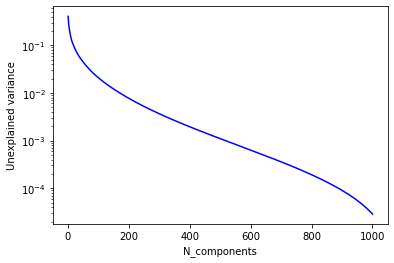

In [10]:
plt.plot(range(1, 1001), 1 - np.cumsum(pca.explained_variance_ratio_), "b-")
plt.yscale("log")
plt.ylabel("Unexplained variance")
plt.xlabel("N_components")
plt.show()

In [11]:
dataset.compute_pca(50, transform=True)
dataset.to_torch()
[(sim.shape, sim.dtype) for sim in dataset]

[((240, 332, 362), dtype('float32')),
 ((600, 332, 362), dtype('float32')),
 ((240, 332, 362), dtype('float32'))]

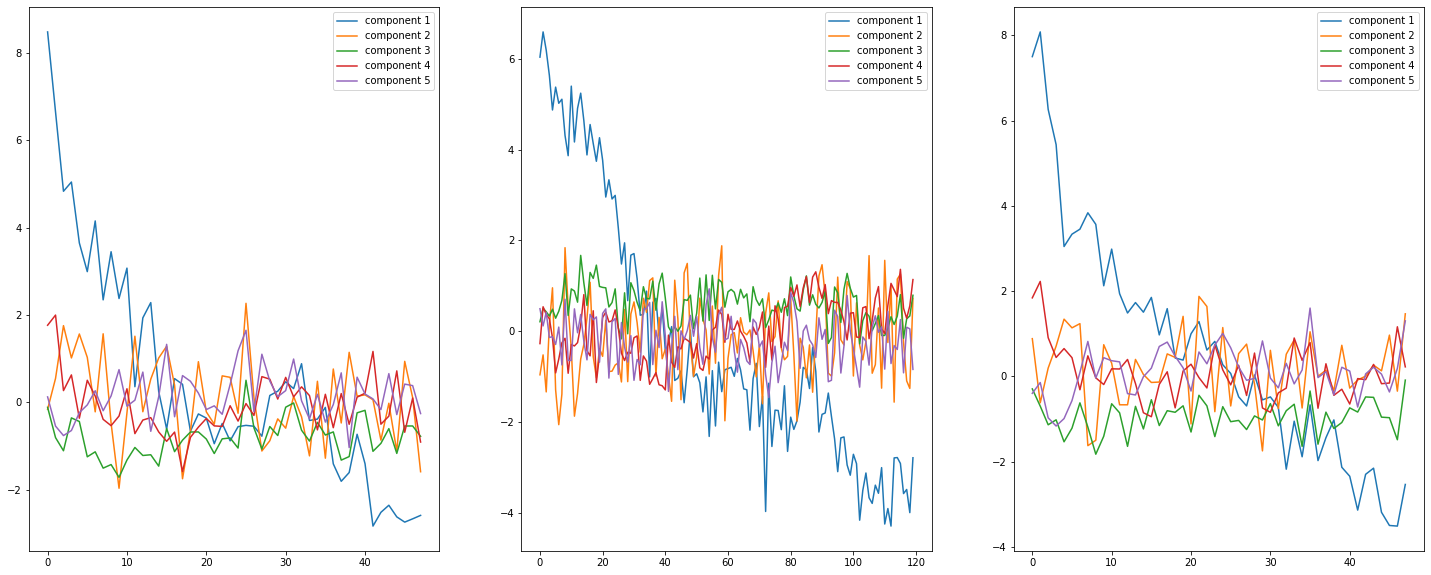

In [12]:
import random

plt.figure(figsize=(25,10))
for i in range(len(dataset.masked_simulations)):
    plt.subplot(1, len(dataset.masked_simulations), i+1)
    for j in range(5):
        plt.plot(dataset.masked_simulations[i][::5, j], label=f"component {j+1}")
    plt.legend()
plt.show()

In [13]:
from eofs.standard import Eof

eof = []
pc = []
for simulation in dataset:
    solver = Eof(simulation)
    eof.append(solver.eofsAsCovariance(neofs=3))
    pc.append(solver.pcs(npcs=3, pcscaling=1))

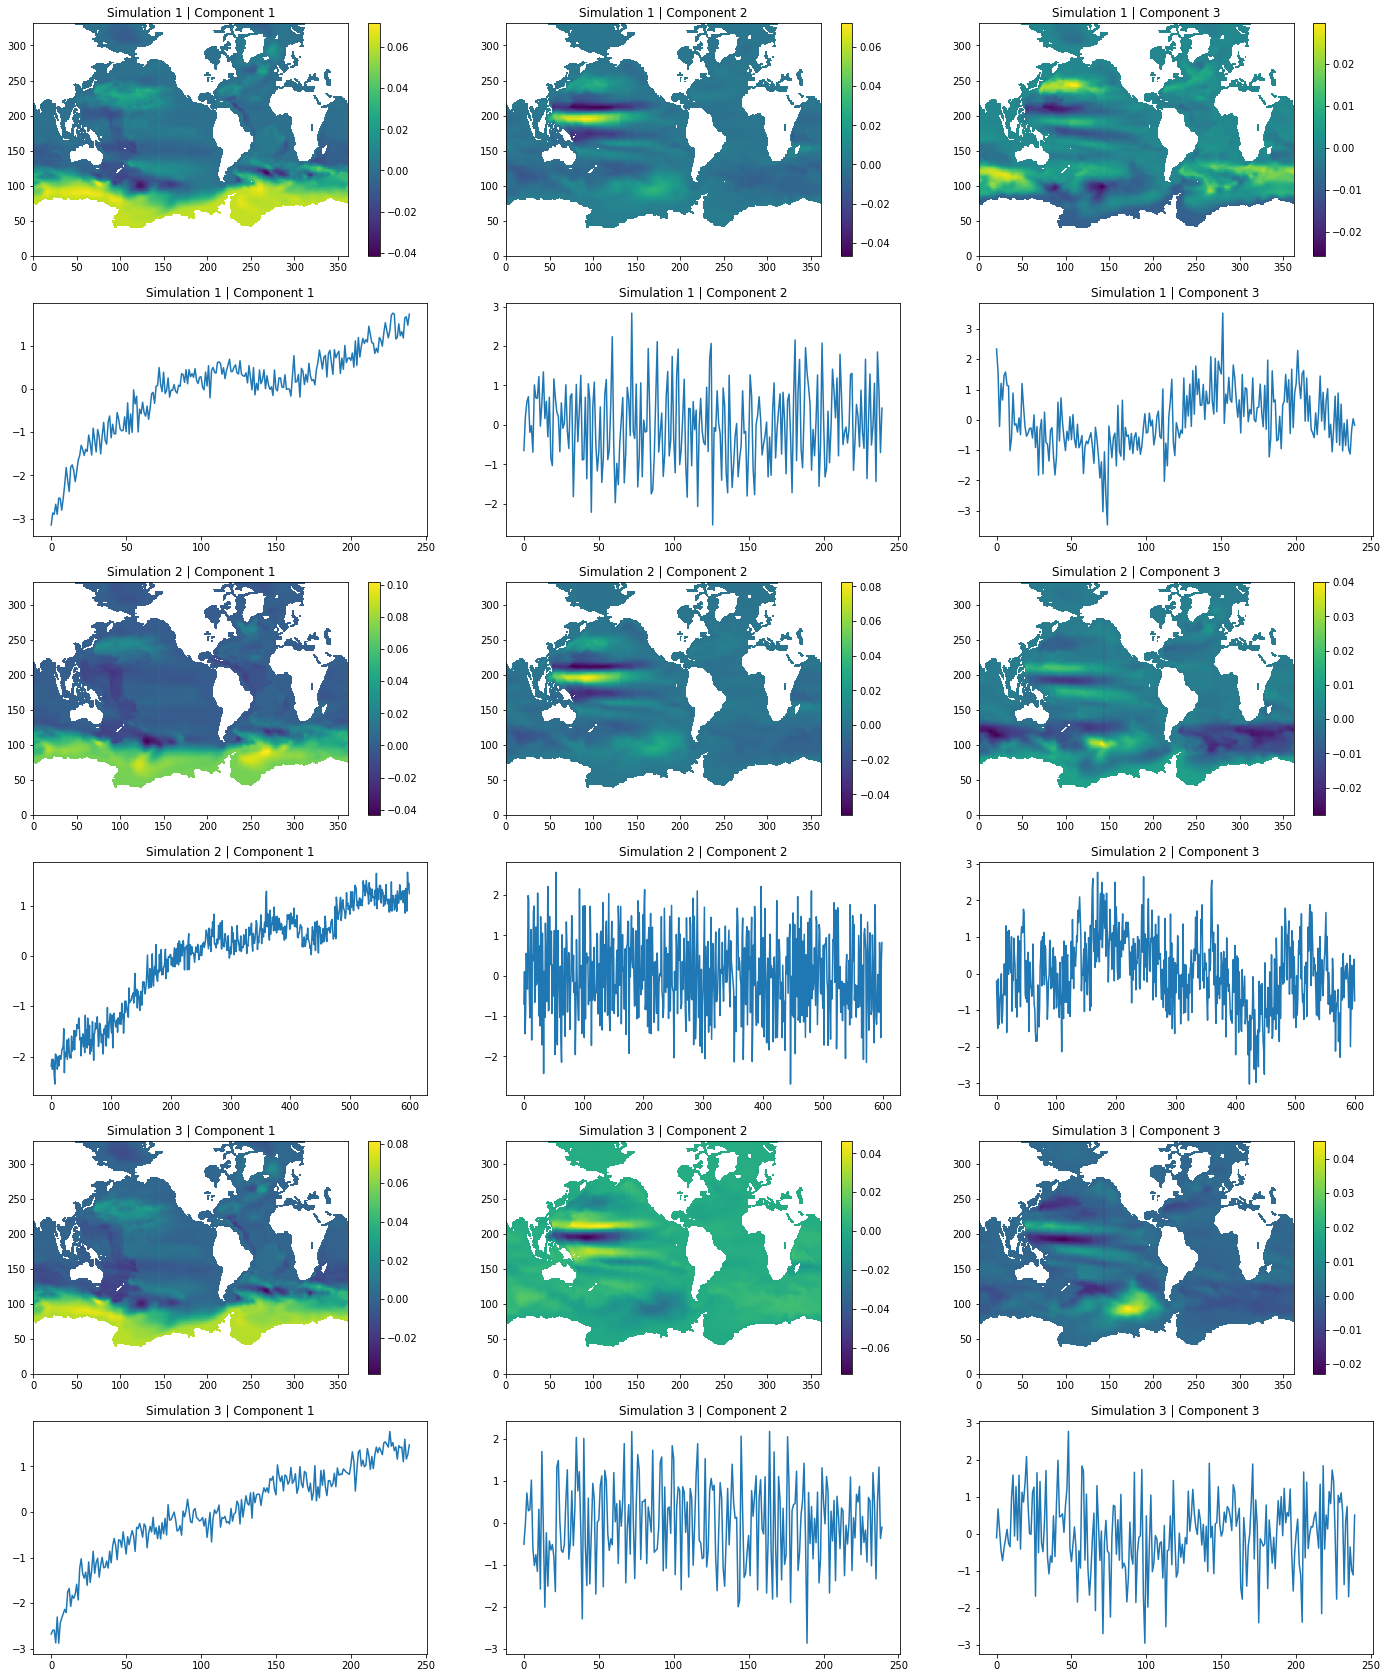

In [14]:
plt.figure(figsize=(24, 30))
k = 0
for i in range(3):
    for j in range(3):
        k += 1
        plt.subplot(6, 3, k)
        plt.pcolor(eof[i][j])
        plt.colorbar()
        plt.title(f"Simulation {i + 1} | Component {j + 1}")
    for j in range(3):
        k += 1
        plt.subplot(6, 3, k)
        plt.plot(pc[i][:, j])
        plt.title(f"Simulation {i + 1} | Component {j + 1}")

plt.show()

## Training preparation

In [15]:
dataset.make_input_indices()

In [16]:
train_ds, test_ds = dataset.train_test_ds()
print(len(train_ds), len(test_ds))

855 216


In [17]:
train_dataloader, test_dataloader = dataset.make_dataloaders(train_ds, test_ds)

In [18]:
model, criterion, optimizer = modellib.define_model_optimizer_criterion(pca_model=True)

Model has 126850 parameters


## Training 

Epoch  1


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  6


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  7


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  8


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  9


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  10


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  11


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  12


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  13


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  14


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  15


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  16


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  17


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  18


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  19


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  20


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  21


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  22


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  23


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  24


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  25


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  26


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  27


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  28


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  29


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  30


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  31


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  32


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  33


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  34


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  35


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  36


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  37


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  38


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  39


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  40


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  41


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  42


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  43


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  44


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  45


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  46


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  47


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  48


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  49


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  50


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  51


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  52


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  53


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  54


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  55


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  56


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  57


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  58


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  59


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  60


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  61


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  62


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  63


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  64


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  65


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  66


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  67


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  68


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  69


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  70


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  71


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  72


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  73


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  74


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  75


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  76


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  77


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  78


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  79


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  80


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  81


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  82


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  83


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  84


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  85


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  86


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  87


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  88


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  89


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  90


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  91


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  92


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  93


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  94


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  95


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  96


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  97


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  98


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  99


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch  100


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

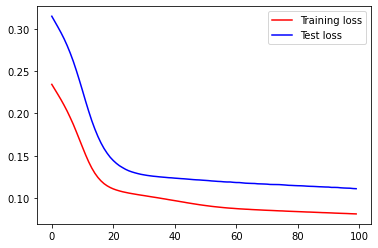

Final test loss: 0.1111002125673824


In [19]:
train_losses, test_losses = training.train(model, conf.epochs, train_dataloader, test_dataloader, optimizer, criterion, bool_mask=None)
plt.figure()
plt.plot(train_losses, "r-", label="Training loss")
if conf.epochs != 1:
    plt.plot(test_losses, "b-", label="Test loss")
plt.legend()
plt.show()
print(f"Final test loss: {test_losses[-1]}")

## Result visualization 

Chosen idx: 52
Mean of ground truth: 0.006 ; Std of ground truth: 0.488
Mean of predicted map: 0.003 ; Std of predicted map: 0.493


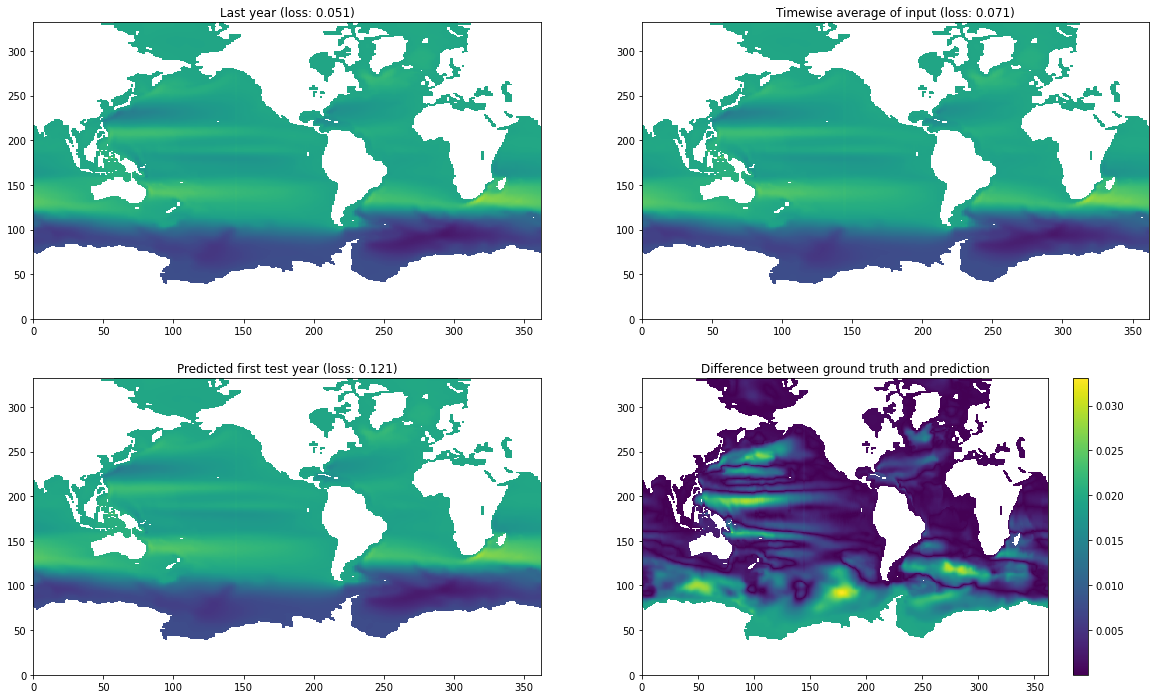

In [20]:
training.test_sample_pca(model, criterion, test_ds, dataset.bool_mask, dataset.pca)
plt.show()

Chosen idx: 187
Mean of ground truth: 0.007 ; Std of ground truth: 0.486
Mean of predicted map: 0.004 ; Std of predicted map: 0.492


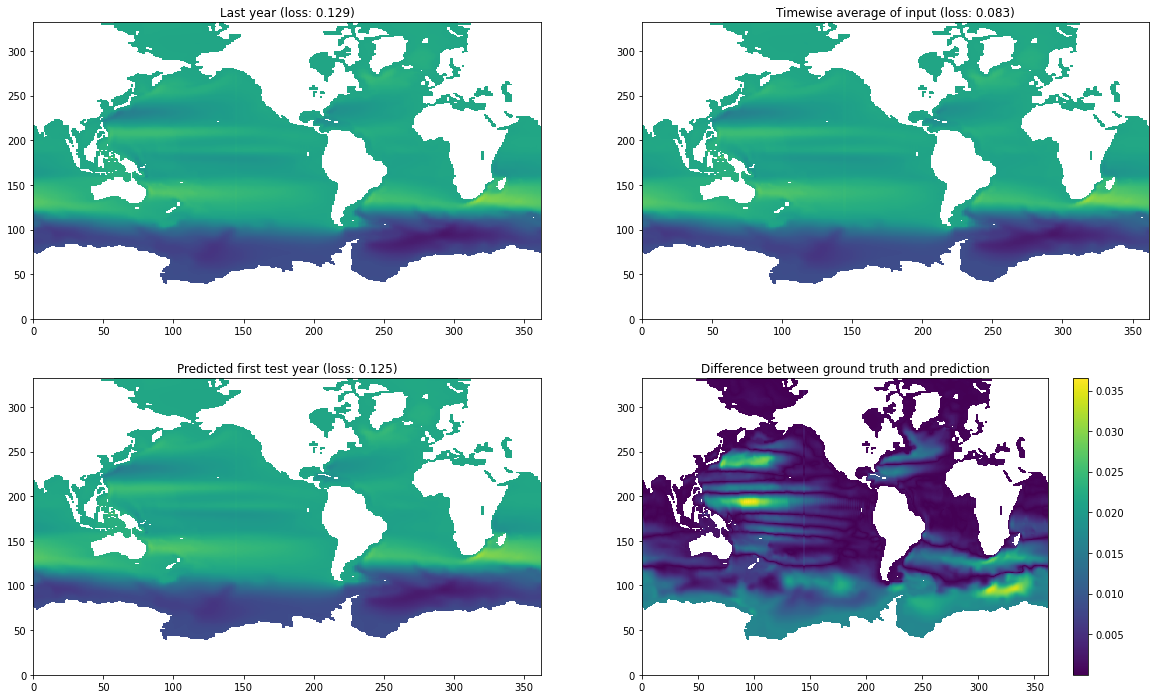

In [21]:
training.test_sample_pca(model, criterion, test_ds, dataset.bool_mask, dataset.pca)
plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([1, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


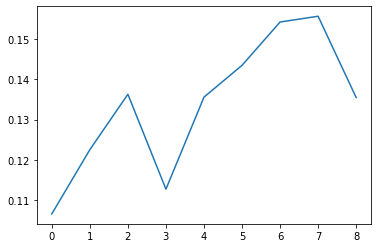

In [22]:
losses = training.quantify_quality_average(model, criterion, test_ds, dataset.bool_mask)
plt.plot(losses) ; plt.show()